In [1]:
import geopandas as gpd
import glob
import intake
import os
import sys

from loguru import logger

import open_data_utils
from calitp_data_analysis.geography_utils import WGS84
from calitp_data_analysis import utils
from calitp_data_analysis.gcs_geopandas import GCSGeoPandas
gcsgp = GCSGeoPandas()
from update_vars import analysis_date, RUN_ME

# import google.auth
# credentials, project = google.auth.default()

catalog = intake.open_catalog("./catalog.yml")

# Look at Route Typology Data

In [2]:
RUN_ME

['ca_hq_transit_areas',
 'ca_hq_transit_stops',
 'ca_transit_routes',
 'ca_transit_stops',
 'speeds_by_stop_segments',
 'speeds_by_route_time_of_day']

In [3]:
from gcs_to_esri import project_and_standardize_cols

In [27]:
gdf = catalog['ca_transit_routes']().read().pipe(project_and_standardize_cols)

drop: []


In [29]:
typologies = list(gdf.columns)[12:-1]

In [30]:
typologies

['is_express',
 'is_ferry',
 'is_rail',
 'is_coverage',
 'is_local',
 'is_downtown_local',
 'is_rapid']

In [31]:
gdf = gdf.assign(typology_count = gdf[typologies].sum(axis=1))

In [32]:
gdf.typology_count.value_counts()

1    3986
2    2941
Name: typology_count, dtype: int64

In [34]:
gdf.query('typology_count == 2').head(3)

,agency,route_id,route_type,route_name,route_length_feet,shape_id,n_trips,base64_url,shn_route,on_shs,...,pct_route_on_hwy_across_districts,is_express,is_ferry,is_rail,is_coverage,is_local,is_downtown_local,is_rapid,geometry,typology_count
14,Marin County Transit District,23,3,23,48481.949748,33,23,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,101,1,...,5.7,0,0,0,0,1,0,1,"LINESTRING (-122.60413 38.00022, -122.60420 38...",2
15,Marin County Transit District,23,3,23,48922.012576,34,23,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,101,1,...,5.6,0,0,0,0,1,0,1,"LINESTRING (-122.49064 37.95323, -122.49052 37...",2
16,Marin County Transit District,233,3,233,28819.752074,14,13,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,101,1,...,2.0,0,0,0,1,0,0,1,"LINESTRING (-122.51420 38.01331, -122.51417 38...",2


In [37]:
import branca

In [40]:
gdf = gdf[['agency', 'route_name'] + typologies + ['typology_count', 'geometry']]

### Categorical Colormap for Webmap example

* figure out how to make an svg legend with labels, then can add to `webmap_utils`

In [131]:
cmap = branca.colormap.step.Accent_08

In [132]:
cmap = cmap.scale(vmin=0, vmax=len(cmap.colors))

In [144]:
cmap

In [133]:
cmap.index

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [137]:
subset_colors = cmap.colors[:len(typologies)]

In [135]:
cmap_colors_rgb = [cmap.rgb_bytes_tuple(x) for x in range(1, len(cmap.colors)+1)]

In [64]:
typology_cmap = dict(zip(typologies, cmap_colors_rgb))

In [65]:
typology_cmap

{'is_express': (127, 201, 127),
 'is_ferry': (190, 174, 212),
 'is_rail': (253, 192, 134),
 'is_coverage': (255, 255, 153),
 'is_local': (56, 108, 176),
 'is_downtown_local': (240, 2, 127),
 'is_rapid': (191, 91, 23)}

In [ ]:
#  if dict keys are the values you'd like to color on, could apply as:
#  df = df.assign(color = df.column.map(typology_cmap))

In [66]:
#  dict_keys are column names here, look for 1 values and override with gray for multi-typology rows
def color_from_typology(row, typology_cmap):
    
    for typology in typology_cmap.keys():
        if row[typology] == 1: color = typology_cmap[typology]
    if row.typology_count == 2: color = (102, 102, 102)
    return color

In [70]:
gdf = gdf.assign(color = gdf.apply(color_from_typology, axis=1, typology_cmap=typology_cmap))

In [71]:
from shared_utils import webmap_utils

In [73]:
from calitp_data_analysis.geography_utils import CA_NAD83Albers_m

In [74]:
gdf = gdf.to_crs(CA_NAD83Albers_m)

In [75]:
gdf.geometry = gdf.buffer(25)

## Make a few regional and statewide sample maps

![](img/typology_legend.png)

In [ ]:
la_area = gdf.query('agency.str.contains("Los Angeles")')

In [83]:
la_state = webmap_utils.set_state_export(la_area, filename='inspect_typologies_la', map_title='CA Route Typologies la_area Sep 2025 test')

/home/jovyan/data-analyses/_shared_utils/shared_utils/webmap_utils.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = (gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean())


In [150]:
webmap_utils.render_spa_link(la_state, text='LA Map (select agencies)')

<a href="{'state_dict': {'name': 'null', 'layers': [{'name': 'CA Route Typologies la_area Sep 2025 test', 'url': 'https://storage.googleapis.com/calitp-map-tiles/testing/inspect_typologies_la.geojson.gz', 'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}], 'lat_lon': (34.05213228672801, -118.29668785038206), 'zoom': 13}, 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJDQSBSb3V0ZSBUeXBvbG9naWVzIGxhX2FyZWEgU2VwIDIwMjUgdGVzdCIsICJ1cmwiOiAiaHR0cHM6Ly9zdG9yYWdlLmdvb2dsZWFwaXMuY29tL2NhbGl0cC1tYXAtdGlsZXMvdGVzdGluZy9pbnNwZWN0X3R5cG9sb2dpZXNfbGEuZ2VvanNvbi5neiIsICJwcm9wZXJ0aWVzIjogeyJzdHJva2VkIjogZmFsc2UsICJoaWdobGlnaHRfc2F0dXJhdGlvbl9tdWx0aXBsaWVyIjogMC41fX1dLCAibGF0X2xvbiI6IFszNC4wNTIxMzIyODY3MjgwMSwgLTExOC4yOTY2ODc4NTAzODIwNl0sICJ6b29tIjogMTN9'}" target="_blank">Open LA Map (select agencies) in New Tab</a>

In [87]:
bay = ['Marin County Transit District', 'Golden Gate Bridge, Highway and Transportation District', 'City and County of San Francisco',
'Alameda-Contra Costa Transit District', 'San Mateo County Transit District']

In [89]:
bay_area = gdf.query('agency.isin(@bay)')

In [91]:
bay_state = webmap_utils.set_state_export(bay_area, filename='inspect_typologies_bay', map_title='CA Route Typologies bay_area Sep 2025 test')

/home/jovyan/data-analyses/_shared_utils/shared_utils/webmap_utils.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = (gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean())


In [149]:
webmap_utils.render_spa_link(bay_state, text='Bay Area Map (select agencies)')

<a href="{'state_dict': {'name': 'null', 'layers': [{'name': 'CA Route Typologies bay_area Sep 2025 test', 'url': 'https://storage.googleapis.com/calitp-map-tiles/testing/inspect_typologies_bay.geojson.gz', 'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}], 'lat_lon': (37.718703363498435, -122.33616010515051), 'zoom': 13}, 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJDQSBSb3V0ZSBUeXBvbG9naWVzIGJheV9hcmVhIFNlcCAyMDI1IHRlc3QiLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3Rlc3RpbmcvaW5zcGVjdF90eXBvbG9naWVzX2JheS5nZW9qc29uLmd6IiwgInByb3BlcnRpZXMiOiB7InN0cm9rZWQiOiBmYWxzZSwgImhpZ2hsaWdodF9zYXR1cmF0aW9uX211bHRpcGxpZXIiOiAwLjV9fV0sICJsYXRfbG9uIjogWzM3LjcxODcwMzM2MzQ5ODQzNSwgLTEyMi4zMzYxNjAxMDUxNTA1MV0sICJ6b29tIjogMTN9'}" target="_blank">Open Bay Area Map (select agencies) in New Tab</a>

In [97]:
sample2k = gdf.sample(2000)

In [141]:
sample_state = webmap_utils.set_state_export(sample2k, filename='inspect_typologies_sample', map_title='CA Route Typologies sample Sep 2025 test')

/home/jovyan/data-analyses/_shared_utils/shared_utils/webmap_utils.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = (gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean())


In [151]:
webmap_utils.render_spa_link(sample_state, 'Statewide Map (2000 row random sample)')

<a href="{'state_dict': {'name': 'null', 'layers': [{'name': 'CA Route Typologies sample Sep 2025 test', 'url': 'https://storage.googleapis.com/calitp-map-tiles/testing/inspect_typologies_sample.geojson.gz', 'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}], 'lat_lon': (36.3337658841086, -116.51494074297506), 'zoom': 13}, 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJDQSBSb3V0ZSBUeXBvbG9naWVzIHNhbXBsZSBTZXAgMjAyNSB0ZXN0IiwgInVybCI6ICJodHRwczovL3N0b3JhZ2UuZ29vZ2xlYXBpcy5jb20vY2FsaXRwLW1hcC10aWxlcy90ZXN0aW5nL2luc3BlY3RfdHlwb2xvZ2llc19zYW1wbGUuZ2VvanNvbi5neiIsICJwcm9wZXJ0aWVzIjogeyJzdHJva2VkIjogZmFsc2UsICJoaWdobGlnaHRfc2F0dXJhdGlvbl9tdWx0aXBsaWVyIjogMC41fX1dLCAibGF0X2xvbiI6IFszNi4zMzM3NjU4ODQxMDg2LCAtMTE2LjUxNDk0MDc0Mjk3NTA2XSwgInpvb20iOiAxM30='}" target="_blank">Open Statewide Map (2000 row random sample) in New Tab</a>

## Explore Road Segment methodology

below copied/adapted from function here: https://github.com/cal-itp/data-analyses/blob/46801070833f83345200791478412b71b6a0ea68/gtfs_funnel/route_typologies.py#L96

In [100]:
from shared_utils import catalog_utils

In [101]:
GTFS_DATA_DICT = catalog_utils.get_catalog("gtfs_analytics_data")

In [102]:
import sys
sys.path.append('../gtfs_funnel/')

In [103]:
import nacto_utils

In [104]:
SEGMENT_GCS = GTFS_DATA_DICT.gcs_paths.SEGMENT_GCS
RT_SCHED_GCS = GTFS_DATA_DICT.gcs_paths.RT_SCHED_GCS
SCHED_GCS = GTFS_DATA_DICT.gcs_paths.SCHED_GCS
SHARED_GCS = GTFS_DATA_DICT.gcs_paths.SHARED_GCS

In [106]:
import pandas as pd

In [109]:
dict_inputs = GTFS_DATA_DICT

In [111]:
road_cols = ["linearid", "mtfcc", "fullname"]
road_segment_cols = road_cols + ["segment_sequence"]

In [113]:
road_stats = pd.read_parquet(
    f"{SCHED_GCS}arrivals_by_road_segment_{str(2025)}.parquet"
)

ROAD_SEGMENTS = dict_inputs.shared_data.road_segments_twomile

roads = gcsgp.read_parquet(
    f"{SHARED_GCS}{ROAD_SEGMENTS}.parquet",
    columns = road_segment_cols + ["geometry"]
    ).to_crs(CA_NAD83Albers_m)

road_stats = road_stats.assign(
    freq_category = road_stats.apply(
        lambda x: nacto_utils.nacto_peak_frequency_category(x.frequency), axis=1)
)

road_stats = road_stats.assign(
    typology = road_stats.apply(
        lambda x: nacto_utils.nacto_stop_frequency(
        x.stops_per_mi, x.freq_category), axis=1)
)

In [114]:
road_stats

,linearid,mtfcc,fullname,segment_sequence,n_arrivals,n_stops,frequency,stops_per_mi,freq_category,typology
0,11010865750885,S1400,Ovieda Plz,0,11,1,1.38,2.30,low,coverage
1,11010865751019,S1400,Barcelona Plz,0,33,1,4.12,4.30,moderate,downtown_local
2,11010865751020,S1400,Barcelona Plz,0,11,1,1.38,3.51,low,coverage
3,11010865751023,S1400,Malaga Plz,0,33,1,4.12,4.03,moderate,downtown_local
4,11010865843410,S1400,Wedemeyer St,0,64,4,8.00,3.21,moderate,local
...,...,...,...,...,...,...,...,...,...,...
67484,1109098041686,S1400,W Sierra Madre Ave,1,31,1,3.88,2.36,low,coverage
67485,1109098041973,S1400,N Hillcrest Rd,0,92,2,11.50,0.50,high,None
67486,1109098042162,S1400,Ladybug Ln,0,5,1,0.62,2.54,low,coverage
67487,1109098042166,S1400,Camden Dr,0,10,1,1.25,2.03,low,coverage


<Axes: >

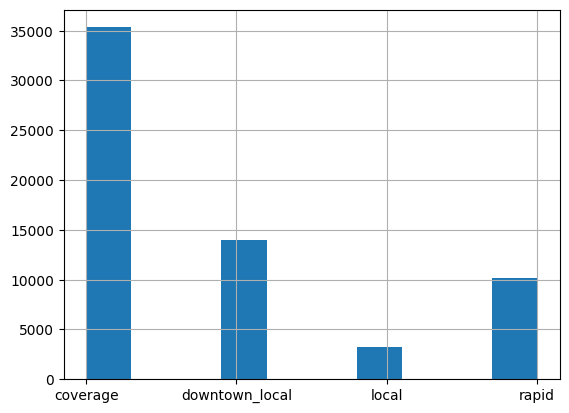

In [116]:
road_stats.typology.hist()

In [119]:
gdf[typologies].sum()

is_express            276
is_ferry               53
is_rail               283
is_coverage          3477
is_local             1059
is_downtown_local    2776
is_rapid             1944
dtype: int64